# ! Bu çalışma bir yatırım tavisyesi değildir!  Veri bilimi ve derin öğrenme disiplinliklerinde öğrenmek adına bir çalışmadır.

In [19]:
# İndirilmesi gereken kütüpaneler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from datetime import timedelta

In [7]:
# Veri setinin yüklenmesi
data = pd.read_csv(r'C:\Users\realb\Desktop\apple hisse senedi fiyatı LSTM ile fiyat  analizi\AAPL_daily_update.csv')

In [8]:
# 'Date' adlı sütünü index olacak şkilde datetime veri formatına çeviriyor.
# Bunu LSTM modeli için uygun hale getirmek durumundayız.
data['Date'] = pd.to_datetime(data['Date'])

In [9]:
# 'Date' adlı veri sütünündaki date verierlini datetime cevirme işleminden sonra veri setine set edilme işlemini yapıyorum.
data.set_index('Date', inplace=True)

In [10]:
# LSTM modeli için yalnızca 'Kapanış' fiyatlarını kullanın
close_data = data[['Close']]

In [11]:
# Verileri normalleştirin
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_data)

In [12]:
# Veri dizileri oluşturmak için bir işlev tanımlayın
# Bunu yapma nedeni LSTM modeli geçmiş verilerin ağırlığını etki etme işlemleri uygulancak ama bu uygulanma işlemlerinin kaç adım yapılması.
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)

# Sıra uzunluğunu ayarlayın
# Yapılan işlemin kaç adımlı olması işlemi yapılmasının sağlanması.
sequence_length = 60

# Diziler oluştur
X, y = create_sequences(scaled_data, sequence_length)

# Verileri eğitim ve test setlerine ayırın
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [13]:
# LSTM modelinin kurulması
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [14]:
# Kurulan modelin ayarlarının yapılması.
model.compile(optimizer='adam', loss='mean_squared_error')

In [15]:
# Modelin train edilmesi ve test işlemleri için veri seti ayrılması, epoch sayısı, batch sayısının tanımlanması.
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), shuffle=False)

Epoch 1/50
5/5 [==============================] - 3s 160ms/step - loss: 0.0211 - val_loss: 0.0295
Epoch 2/50
5/5 [==============================] - 0s 31ms/step - loss: 0.0184 - val_loss: 0.0768
Epoch 3/50
5/5 [==============================] - 0s 31ms/step - loss: 0.0095 - val_loss: 0.0746
Epoch 4/50
5/5 [==============================] - 0s 31ms/step - loss: 0.0037 - val_loss: 0.0172
Epoch 5/50
5/5 [==============================] - 0s 31ms/step - loss: 0.0053 - val_loss: 0.0137
Epoch 6/50
5/5 [==============================] - 0s 31ms/step - loss: 0.0048 - val_loss: 0.0307
Epoch 7/50
5/5 [==============================] - 0s 31ms/step - loss: 0.0034 - val_loss: 0.0265
Epoch 8/50
5/5 [==============================] - 0s 30ms/step - loss: 0.0027 - val_loss: 0.0123
Epoch 9/50
5/5 [==============================] - 0s 33ms/step - loss: 0.0029 - val_loss: 0.0106
Epoch 10/50
5/5 [==============================] - 0s 31ms/step - loss: 0.0029 - val_loss: 0.0156
Epoch 11/50
5/5 [===========

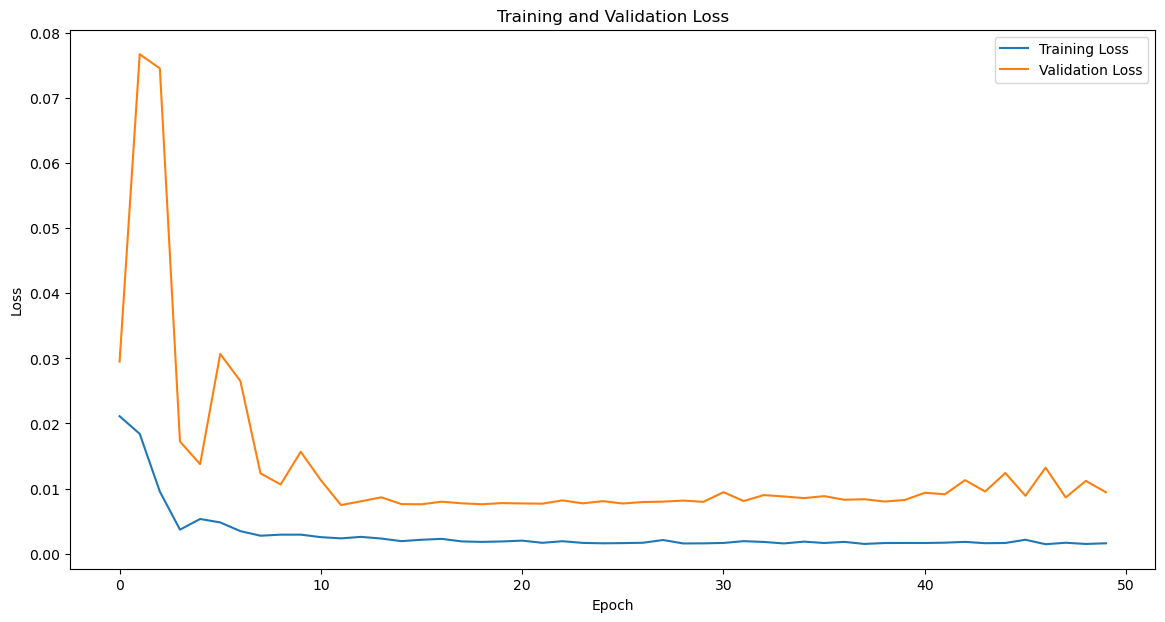

In [16]:
# Modelin eğitim sırasındaki hata ve diğer sayılarının verilerinin görselleştirilmesi.
plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
# Modele test yapılması işleminin yapılması.
predictions = model.predict(X_test)

# Tahmin işlminindeki verileri geri tablodoki veri formatına inverse edilmesi.
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)

2/2 [==============================] - 1s 6ms/step


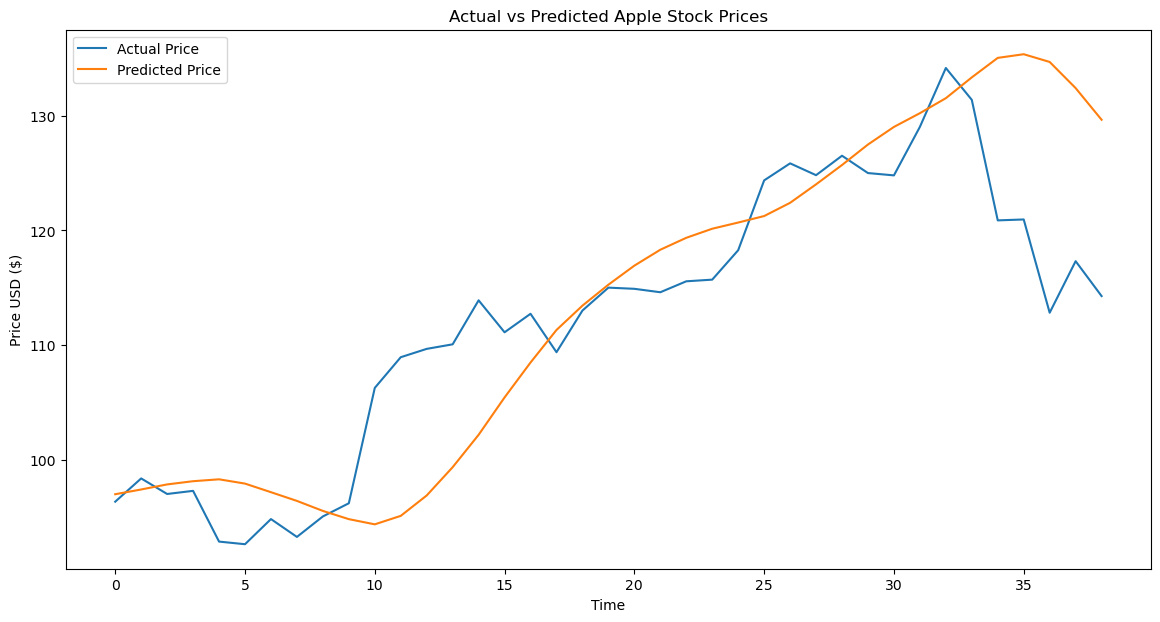

In [18]:
# tahmin sonuçlarını gerçek değerler üzerinden görselleştirlmesi.
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Actual Price')
plt.plot(predictions, label='Predicted Price')
plt.title('Actual vs Predicted Apple Stock Prices')
plt.xlabel('Time')
plt.ylabel('Price USD ($)')
plt.legend()
plt.show()

In [ ]:
# FAltı aylık fiyat tahmini yapılması.
future_days = 1 * 126  # Bir yılda 252 gün çalışan yapı 1 * 126 demek altı aylık tahmin yapması demektir.

# Initialize the last sequence
last_sequence = scaled_data[-sequence_length:]

future_predictions = []

for _ in range(future_days):
    next_pred = model.predict(last_sequence.reshape(1, sequence_length, 1))
    future_predictions.append(next_pred[0, 0])
    last_sequence = np.append(last_sequence[1:], next_pred)

1/1 [==============================] - 0s 16ms/step


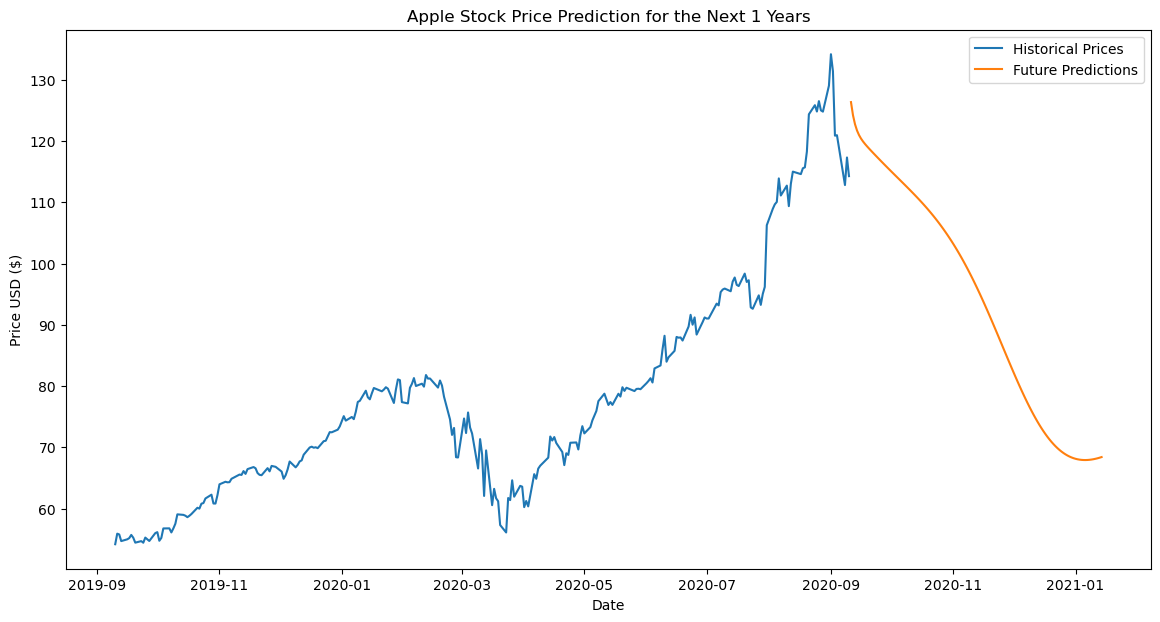

In [23]:
# Tahminleri ters dönüştür
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Gelecekteki tarihler oluşturun
last_date = data.index[-1]
future_dates = [last_date + timedelta(days=i) for i in range(1, future_days + 1)]

# Gelecek tahminlerini çizin
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], label='Historical Prices')
plt.plot(future_dates, future_predictions, label='Future Predictions')
plt.title('Apple Stock Price Prediction for the Next 1 Years')
plt.xlabel('Date')
plt.ylabel('Price USD ($)')
plt.legend()
plt.show()

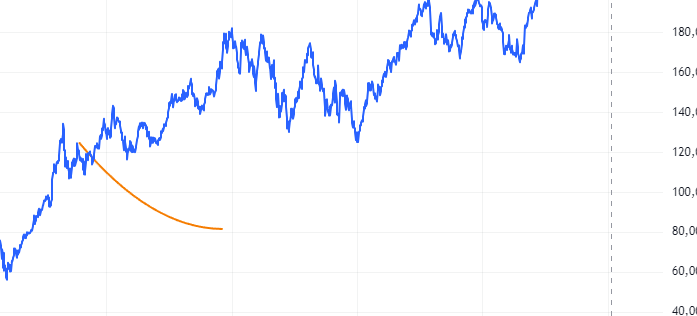

In [24]:
# Bu işlemler yatırım tavsiyesi değilidr.
# Bu ornekde veri kümesi yetersizliği kulanılan model ve hiper paremetreleri ayarlanması.
# yada öreneğin piyasadaki trende göre modelin yeniden ayarlanması. Bu burumda gerçekten fianansçılardan yardım alnımalıdır.